In [1]:
%load_ext autoreload
%autoreload 2

# import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import uproot
from scipy.stats import iqr

from hepattn.experiments.clic.performance.performance import Performance
from hepattn.experiments.clic.performance.plot_helper_event import *
from hepattn.experiments.clic.performance.plot_helper_particle import *

In [3]:
save_dir = "/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/maskformer_infer_best"
SAVE_FIG = True

In [4]:
os.makedirs(save_dir, exist_ok=True)

In [5]:
net_dict = {
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFix_20250611-T181526/ckpts/epoch=172-val_loss=3.29018__test.root",
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test.root",
    # "mpflow":   "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test__common.root",
    "mpflow": "/share/gpu1/syw24/hepattn/logs/CLIC_Pflow_FullDiceFocFix_bf16_mixed_4gpu_20250628-T205247/ckpts/epoch=163-val_loss=1.41597__test.root",
    # "hgpflow": "/storage/agrp/nilotpal/HGPFlow_v2/experiments/hgpflow_v2/clicxminixbig1x2xs2xxxds7kirm1yo/inference/ee_qq_new/pred_test_p8_ee_qq_ecm380_20k_seg_bw0.3_nocut_merged.root",
    # 'hgpflow'
}

In [6]:
perf_obj = Performance(
    # truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_common_raw.root",
    truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_raw.root",
    networks=net_dict,
    # num_events=18000,
    # num_events={
    #     'mpflow' : 25_000,
    # }
)

E, pT will be scaled by 1


Reading truth tree...: 100%|████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.71it/s]


Number of events with at least one track or topocluster: 24999 out of 25000
[[17479]]
Number of events after filtering: 24999


Computing mpflow mass...: 100%|████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:00<00:00, 26619.12it/s]


In [7]:
perf_obj.reorder_and_find_intersection()

common event count: 24728


Filtering and reordering mpflow...: 100%|█████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1445.07it/s]


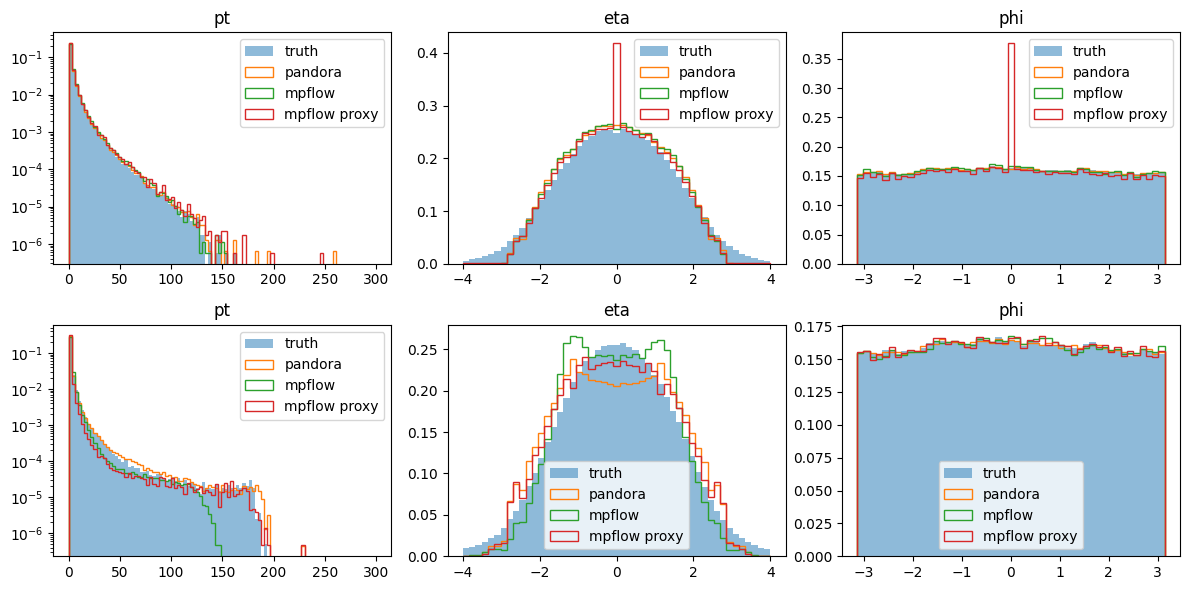

In [8]:
bins = [
    np.linspace(0, 300, 100),
    np.linspace(-4, 4, 50),
    np.linspace(-np.pi, np.pi, 50),
]
var_names = ["pt", "eta", "phi"]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
mask_fns = [
    lambda x: x < 3,
    lambda x: (x < 5) & (x > 2),
]
truth_class = np.concatenate(perf_obj.truth_dict["particle_class"])
pandora_class = np.concatenate(perf_obj.truth_dict["pandora_class"])

for i in range(3):
    for j in range(2):
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["particle_" + var_names[i]])[mask_fns[j](truth_class)],
            bins=bins[i],
            histtype="stepfilled",
            alpha=0.5,
            label="truth",
            density=True,
        )
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["pandora_" + var_names[i]])[mask_fns[j](pandora_class)],
            bins=bins[i],
            histtype="step",
            label="pandora",
            density=True,
        )
        for key, value in perf_obj.data.items():
            pf_class = np.concatenate(value["class"])
            ax[j, i].hist(
                np.concatenate(value[var_names[i]])[mask_fns[j](pf_class)],
                bins=bins[i],
                histtype="step",
                label=key,
                density=True,
            )
            if key in {"hgpflow", "mpflow"}:
                ax[j, i].hist(
                    np.concatenate(value["proxy_" + var_names[i]])[mask_fns[j](pf_class)],
                    bins=bins[i],
                    histtype="step",
                    label=key + " proxy",
                    density=True,
                )
        ax[j, i].set_title(var_names[i])
        ax[j, i].legend()
        ax[j, 0].set_yscale("log")

plt.tight_layout()
plt.show()

In [9]:
def get_n_particles(data_dict, key="class"):
    n_charged = []
    n_neutral = []
    for i in range(len(data_dict[key])):
        ch_mask = data_dict[key][i] <= 2
        n_charged.append(np.sum(ch_mask))
        n_neutral.append(np.sum(~ch_mask))
    return np.array(n_charged), np.array(n_neutral)

In [10]:
n_charged_truth, n_neutral_truth = get_n_particles(perf_obj.truth_dict, key="particle_class")
n_charged_pandora, n_neutral_pandora = get_n_particles(perf_obj.truth_dict, key="pandora_class")

for key in perf_obj.data.keys():
    n_charged, n_neutral = get_n_particles(perf_obj.data[key])
    perf_obj.data[key]["n_charged"] = n_charged
    perf_obj.data[key]["n_neutral"] = n_neutral

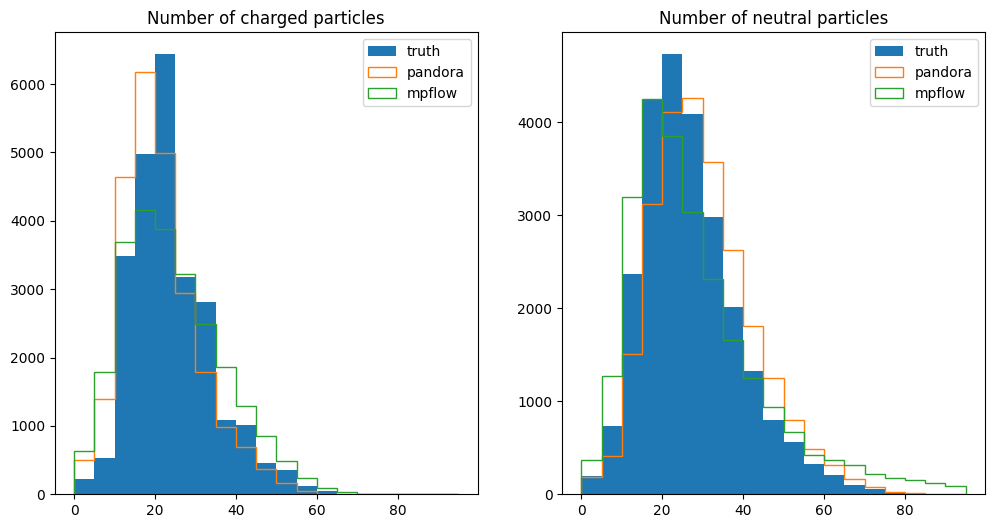

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(n_charged_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[1].hist(n_neutral_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[0].hist(n_charged_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
ax[1].hist(n_neutral_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    ax[0].hist(n_charged, bins=np.arange(0, 100, 5), histtype="step", label=key)
    ax[1].hist(n_neutral, bins=np.arange(0, 100, 5), histtype="step", label=key)
ax[0].legend()
ax[1].legend()
ax[0].set_title("Number of charged particles")
ax[1].set_title("Number of neutral particles")
plt.show()

In [12]:
def _add_hist(ax, data, bins, label, histtype="step", **kwargs):
    mean, iqr_ = np.mean(data), iqr(data)
    label = rf"{label}: $\mu$={mean:.2f}, iqr={iqr_:.2f}"
    ax.hist(data, bins=bins, histtype=histtype, label=label, **kwargs)

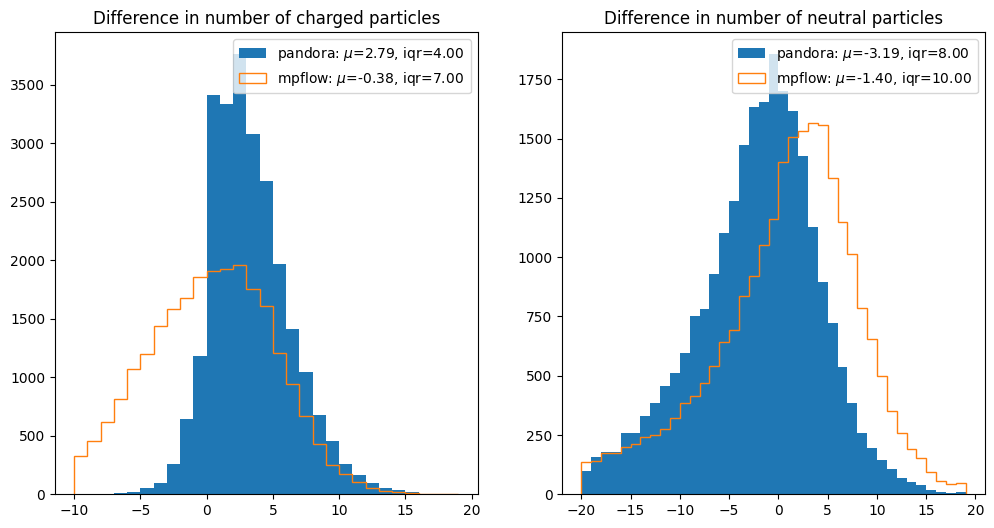

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
_add_hist(ax[0], n_charged_truth - n_charged_pandora, bins=np.arange(-10, 20, 1), histtype="stepfilled", label="pandora")
_add_hist(ax[1], n_neutral_truth - n_neutral_pandora, bins=np.arange(-20, 20, 1), histtype="stepfilled", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    _add_hist(ax[0], n_charged_truth - n_charged, bins=np.arange(-10, 20, 1), label=key, histtype="step")
    _add_hist(ax[1], n_neutral_truth - n_neutral, bins=np.arange(-20, 20, 1), label=key, histtype="step")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Difference in number of charged particles")
ax[1].set_title("Difference in number of neutral particles")
plt.show()

(array([ 728., 4259., 6498., 5269., 3234., 2227., 1211.,  627.,  423.,
         252.]),
 array([  0. ,  14.8,  29.6,  44.4,  59.2,  74. ,  88.8, 103.6, 118.4,
        133.2, 148. ]),
 <BarContainer object of 10 artists>)

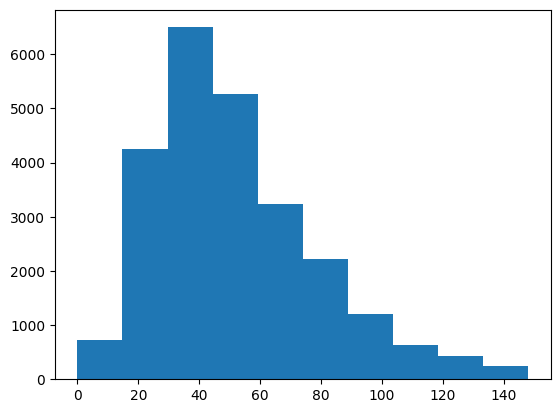

In [14]:
plt.hist(n_charged + n_neutral)

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [15]:
# perf_obj.data["hgpflow"]["eta"] = perf_obj.data["hgpflow"]["proxy_eta"]
# perf_obj.data["hgpflow"]["phi"] = perf_obj.data["hgpflow"]["proxy_phi"]
# perf_obj.data["hgpflow"]["pt"] = perf_obj.data["hgpflow"]["proxy_pt"]

# for i in range(len(perf_obj.data["hgpflow"]["pt"])):
#     ch_mask = perf_obj.data["hgpflow"]["class"][i] <= 2
#     perf_obj.data["hgpflow"]["pt"][i][ch_mask] = perf_obj.data["hgpflow"]["proxy_pt"][i][ch_mask]

In [16]:
idx = 0

print("Particle data")
print(np.sort(perf_obj.truth_dict["particle_pt"][idx][perf_obj.truth_dict["particle_class"][idx] <= 2])[::-1])
print("MPflow proxy data")
print(np.sort(perf_obj.data["mpflow"]["proxy_pt"][idx][perf_obj.data["mpflow"]["class"][idx] <= 2])[::-1])
# print("HGPflow proxy data")
# print(np.sort(perf_obj.data['hgpflow']['proxy_pt'][idx][perf_obj.data['hgpflow']['class'][idx] <= 2])[::-1])

Particle data
[22.68040657  9.80447769  4.84874296  3.93368745  3.68394566  3.14503121
  2.60827255  2.39196706  2.09633183  1.96743882  1.35374236  1.34088707
  1.14111745  1.00602424  0.70337182  0.70083827  0.68998379  0.63668203
  0.44614998  0.09880546]
MPflow proxy data
[9.781012   4.839227   4.0573926  3.6415377  3.6415377  3.1533294
 2.363066   2.363066   2.0483649  1.9732016  1.4224751  1.3599572
 1.1239315  1.0143477  1.0143477  0.719316   0.719316   0.719316
 0.43903565 0.        ]


In [17]:
with uproot.open("/share/gpu1/syw24/dmitrii_clic/test_clic_common_raw.root") as f:
    track_pt = f["events;1"]["track_pt"].array(library="np")

In [18]:
track_pt[0]

array([2.05576324, 2.00231314, 1.22795355, 0.94966769, 0.94607526,
       0.60721469, 0.57421523, 0.52669734, 0.45971552, 0.45850766,
       0.26150492, 0.14520171, 0.23455974, 0.22790611, 0.18378501,
       1.22328436, 0.32035479, 0.57939988, 0.5837239 ])

In [ ]:
perf_obj.compute_jets(n_procs=20)
perf_obj.match_jets()

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7
truth
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|█▋                                                                                       | 23/1236 [00:00<00:09, 127.04it/s]

Jet clustering algorithm: 

Computing jets...:   4%|███▌                                                                                     | 50/1236 [00:00<00:06, 191.10it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:   3%|███                                                                                      | 42/1236 [00:00<00:05, 210.89it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  12%|██████████▏                                                                             | 143/1236 [00:00<00:04, 241.48it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  28%|████████████████████████▉                                                               | 350/1236 [00:01<00:03, 238.41it/s]

Jet clustering algorithm:  

Computing jets...:  21%|██████████████████▎                                                                     | 257/1237 [00:01<00:03, 258.17it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  33%|████████████████████████████▌                                                           | 402/1236 [00:01<00:03, 249.16it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:   6%|█████                                                                                    | 70/1237 [00:00<00:04, 235.78it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  12%|██████████▉                                                                             | 153/1237 [00:00<00:04, 250.44it/s]

Jet clustering algorithm: #--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#-------------------------------------------

Computing jets...:   4%|███▋                                                                                     | 51/1236 [00:00<00:06, 172.28it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:   3%|██▌                                                                                      | 36/1236 [00:00<00:09, 120.01it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  18%|████████████████▏                                                                       | 227/1237 [00:00<00:04, 228.96it/s]

0.7

Computing jets...:  48%|██████████████████████████████████████████▏                                             | 593/1236 [00:02<00:03, 197.35it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  55%|████████████████████████████████████████████████                                        | 675/1236 [00:02<00:02, 244.99it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   5%|████▏                                                                                    | 59/1236 [00:00<00:05, 213.61it/s]

Jet clustering algorithm: #--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#-------------------------------------------

Computing jets...:  53%|███████████████████████████████████████████████                                         | 661/1237 [00:02<00:02, 202.27it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...:  21%|██████████████████▋                                                                     | 262/1236 [00:01<00:03, 255.96it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  18%|███████████████▋                                                                        | 220/1237 [00:00<00:03, 265.00it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...:  75%|██████████████████████████████████████████████████████████████████                      | 928/1236 [00:03<00:01, 266.44it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  36%|████████████████████████████████                                                        | 451/1236 [00:02<00:04, 185.14it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...:  27%|███████████████████████▉                                                                | 337/1236 [00:01<00:03, 239.01it/s]

Jet clustering algorithm:  genkt#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------

Jet clustering radius:  0.7


Computing jets...:  41%|████████████████████████████████████▍                                                   | 513/1237 [00:02<00:03, 195.98it/s]

Jet clustering algorithm:  genkt
#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Jet clustering radius:  0.7


Computing jets...:  43%|█████████████████████████████████████▉                                                  | 534/1237 [00:02<00:03, 181.20it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...:  97%|████████████████████████████████████████████████████████████████████████████████████   | 1194/1236 [00:05<00:00, 160.98it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...:  79%|█████████████████████████████████████████████████████████████████████▊                  | 982/1237 [00:04<00:01, 131.50it/s]

Jet clustering algorithm:  genkt

Computing jets...:  35%|██████████████████████████████▌                                                         | 429/1237 [00:02<00:04, 181.54it/s]


Jet clustering radius:  0.7


Computing jets...:  34%|█████████████████████████████▉                                                          | 420/1236 [00:02<00:05, 140.51it/s]

Jet clustering algorithm: 

Computing jets...:  85%|█████████████████████████████████████████████████████████████████████████▊             | 1050/1237 [00:04<00:00, 246.61it/s]

 genkt

Computing jets...:  85%|██████████████████████████████████████████████████████████████████████████             | 1052/1236 [00:04<00:01, 170.29it/s]

Computing jets...:  58%|██████████████████████████████████████████████████▊                                     | 715/1237 [00:03<00:02, 202.01it/s]

Jet clustering radius:  0.7


Computing jets...:  27%|████████████████████████▏                                                               | 339/1236 [00:02<00:05, 149.68it/s]

Jet clustering algorithm:  genkt


Computing jets...:  72%|███████████████████████████████████████████████████████████████▏                        | 887/1236 [00:04<00:01, 179.81it/s]

Jet clustering radius:  0.7


Computing jets...:  17%|███████████████▏                                                                        | 213/1236 [00:01<00:07, 142.56it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|███████████████████▋                                                                    | 277/1236 [00:01<00:06, 145.09it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  17%|██████████████▉                                                                         | 209/1236 [00:01<00:05, 187.98it/s]

Jet clustering algorithm: 

Computing jets...:  76%|███████████████████████████████████████████████████████████████████▎                    | 946/1237 [00:04<00:01, 215.93it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  17%|███████████████▏                                                                        | 214/1237 [00:01<00:05, 190.35it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:05<00:00, 225.64it/s]


pandora
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|███▉                                                                                     | 54/1236 [00:00<00:04, 260.94it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  12%|██████████▍                                                                             | 147/1236 [00:00<00:03, 281.51it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|███████████████████▊                                                                    | 278/1236 [00:01<00:03, 256.52it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|███▎                                                                                     | 46/1236 [00:00<00:05, 228.15it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   5%|████                                                                                     | 56/1237 [00:00<00:04, 260.15it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  39%|██████████████████████████████████▎                                                     | 482/1236 [00:01<00:02, 284.00it/s]

Jet clustering algorithm:  genkt


Computing jets...:  35%|███████████████████████████████                                                         | 436/1236 [00:01<00:02, 277.42it/s]

Jet clustering radius:  0.7


Computing jets...:  10%|████████▋                                                                               | 122/1236 [00:00<00:04, 247.31it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  25%|██████████████████████▎                                                                 | 313/1236 [00:01<00:04, 197.11it/s]

Jet clustering algorithm: 

Computing jets...:  52%|█████████████████████████████████████████████▎                                          | 637/1236 [00:02<00:02, 273.51it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  18%|████████████████                                                                        | 226/1236 [00:00<00:04, 231.88it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  66%|██████████████████████████████████████████████████████████▏                             | 818/1236 [00:03<00:01, 249.83it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  14%|████████████▏                                                                           | 172/1236 [00:00<00:06, 176.97it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  80%|█████████████████████████████████████████████████████████████████████▉                  | 983/1236 [00:03<00:00, 254.22it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  49%|██████████████████████████████████████████▉                                             | 603/1237 [00:02<00:02, 243.50it/s]

Computing jets...:  27%|███████████████████████▎                                                                | 328/1236 [00:01<00:04, 203.16it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  52%|█████████████████████████████████████████████▊                                          | 644/1236 [00:02<00:02, 207.56it/s]

Jet clustering algorithm:  genkt


Computing jets...:  27%|███████████████████████▉                                                                | 336/1237 [00:01<00:06, 142.09it/s]

Jet clustering radius:  0.7


Computing jets...:  61%|█████████████████████████████████████████████████████▍                                  | 751/1236 [00:03<00:02, 224.72it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|████████████████████████████████████▍                                                   | 512/1237 [00:03<00:03, 181.81it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  76%|███████████████████████████████████████████████████████████████████▏                    | 945/1237 [00:05<00:02, 125.43it/s]

Computing jets...:  79%|█████████████████████████████████████████████████████████████████████▊                  | 981/1236 [00:04<00:01, 177.20it/s]

Jet clustering algorithm:  

Computing jets...:  71%|██████████████████████████████████████████████████████████████▏                         | 874/1237 [00:04<00:02, 171.83it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  75%|█████████████████████████████████████████████████████████████████▊                      | 925/1237 [00:04<00:02, 143.74it/s]

Jet clustering algorithm:  genkt

Computing jets...:  85%|██████████████████████████████████████████████████████████████████████████▎            | 1055/1236 [00:05<00:01, 153.15it/s]


Jet clustering radius: 

Computing jets...:  88%|████████████████████████████████████████████████████████████████████████████▊          | 1092/1237 [00:06<00:00, 170.74it/s]

Computing jets...:  85%|█████████████████████████████████████████████████████████████████████████▋             | 1047/1236 [00:05<00:01, 181.31it/s]

0.7


Computing jets...:  50%|███████████████████████████████████████████▊                                            | 615/1237 [00:03<00:04, 141.90it/s]

Jet clustering algorithm: 

Computing jets...:  96%|███████████████████████████████████████████████████████████████████████████████████▍   | 1186/1237 [00:06<00:00, 207.44it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1237/1237 [00:05<00:00, 222.55it/s]


mpflow jets
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|██▊                                                                                      | 39/1236 [00:00<00:06, 192.26it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|██▋                                                                                      | 38/1236 [00:00<00:06, 193.14it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|███████▌                                                                                | 107/1237 [00:00<00:05, 195.79it/s]

Jet clustering algorithm:  genkt

Computing jets...:  17%|███████████████▏                                                                        | 214/1236 [00:01<00:05, 196.66it/s]


Jet clustering radius:  0.7


Computing jets...:  17%|███████████████▍                                                                        | 216/1236 [00:01<00:04, 213.43it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  21%|██████████████████▊                                                                     | 264/1236 [00:01<00:04, 199.23it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  12%|██████████▎                                                                             | 144/1236 [00:00<00:05, 204.04it/s]

Jet clustering algorithm:  genkt


Computing jets...:  30%|██████████████████████████▌                                                             | 373/1236 [00:01<00:04, 209.19it/s]

Jet clustering radius:  0.7


Computing jets...:  15%|█████████████▍                                                                          | 189/1236 [00:00<00:05, 195.60it/s]

Jet clustering algorithm:  

Computing jets...:   8%|██████▉                                                                                  | 97/1236 [00:00<00:06, 183.17it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  11%|█████████▍                                                                              | 133/1236 [00:00<00:07, 156.45it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  31%|███████████████████████████▍                                                            | 386/1237 [00:01<00:04, 210.20it/s]

 0.7


Computing jets...:  22%|███████████████████▋                                                                    | 277/1236 [00:01<00:06, 140.01it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  12%|██████████▉                                                                             | 154/1237 [00:00<00:06, 161.06it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  54%|███████████████████████████████████████████████▋                                        | 669/1236 [00:03<00:03, 162.66it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  25%|██████████████████████▎                                                                 | 313/1236 [00:02<00:06, 132.36it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  61%|█████████████████████████████████████████████████████▎                                  | 750/1237 [00:03<00:02, 200.58it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  15%|████████████▉                                                                           | 182/1236 [00:01<00:07, 135.00it/s]

Jet clustering algorithm:  

Computing jets...:  42%|████████████████████████████████████▋                                                   | 516/1237 [00:03<00:05, 120.52it/s]

genkt


Computing jets...:  68%|███████████████████████████████████████████████████████████▉                            | 842/1236 [00:04<00:02, 136.00it/s]

Jet clustering radius:  0.7


Computing jets...:   8%|███████▏                                                                                | 101/1236 [00:00<00:10, 107.74it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  80%|██████████████████████████████████████████████████████████████████████▏                 | 986/1237 [00:05<00:01, 165.27it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|████████                                                                                | 113/1236 [00:00<00:08, 125.97it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  56%|█████████████████████████████████████████████████▏                                      | 692/1237 [00:04<00:04, 135.81it/s]

0.7


Computing jets...:  34%|█████████████████████████████▌                                                          | 415/1237 [00:03<00:06, 124.14it/s]

Jet clustering algorithm:  genkt

Computing jets...:   9%|███████▉                                                                                | 111/1237 [00:01<00:10, 111.27it/s]


Jet clustering radius: 

Computing jets...:  58%|██████████████████████████████████████████████████▋                                     | 712/1237 [00:05<00:04, 116.43it/s]

 0.7


Computing jets...:  35%|██████████████████████████████▍                                                         | 428/1237 [00:02<00:04, 194.36it/s]

Jet clustering algorithm:  genkt

Computing jets...:  23%|███████████████████▉                                                                    | 280/1236 [00:02<00:08, 116.89it/s]


 Jet clustering radius: 

Computing jets...:   4%|███▎                                                                                     | 46/1236 [00:00<00:10, 110.24it/s]

0.7


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1237/1237 [00:07<00:00, 155.42it/s]


Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|██▊                                                                                      | 39/1236 [00:00<00:06, 194.26it/s]

Jet clustering algorithm:  

Computing jets...:   5%|████▏                                                                                    | 59/1236 [00:00<00:06, 195.23it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:   8%|███████▍                                                                                | 104/1236 [00:00<00:05, 189.37it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   7%|██████▎                                                                                  | 87/1236 [00:00<00:06, 183.64it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|██▋                                                                                      | 38/1236 [00:00<00:06, 187.35it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  11%|█████████▎                                                                              | 131/1237 [00:00<00:05, 187.80it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  16%|█████████████▉                                                                          | 196/1237 [00:01<00:05, 198.77it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  19%|████████████████▍                                                                       | 231/1237 [00:01<00:05, 188.51it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  28%|█████████████████████████                                                               | 352/1236 [00:01<00:04, 208.33it/s]

Jet clustering algorithm:  

Computing jets...:  32%|████████████████████████████                                                            | 394/1237 [00:02<00:03, 221.13it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  28%|████████████████████████▋                                                               | 347/1237 [00:01<00:04, 202.12it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   6%|█████▊                                                                                   | 80/1236 [00:00<00:06, 168.60it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  26%|███████████████████████▏                                                                | 326/1236 [00:01<00:04, 198.52it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  13%|███████████                                                                             | 155/1236 [00:01<00:07, 139.51it/s]

Jet clustering algorithm: 

Computing jets...:  36%|███████████████████████████████▎                                                        | 439/1236 [00:02<00:04, 191.55it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  48%|██████████████████████████████████████████▍                                             | 597/1237 [00:02<00:02, 222.74it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|███▍                                                                                     | 48/1236 [00:00<00:08, 137.17it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  45%|███████████████████████████████████████▎                                                | 552/1236 [00:03<00:04, 162.22it/s]

0.7


Computing jets...:  67%|███████████████████████████████████████████████████████████▍                            | 834/1236 [00:04<00:03, 107.63it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  26%|██████████████████████▋                                                                 | 319/1236 [00:01<00:06, 141.79it/s]

Jet clustering algorithm:  

Computing jets...:  58%|██████████████████████████████████████████████████▋                                     | 713/1237 [00:04<00:04, 113.01it/s]

genkt

Computing jets...:  15%|█████████████                                                                           | 183/1237 [00:01<00:07, 145.38it/s]


Jet clustering radius:  0.7


Computing jets...:  62%|██████████████████████████████████████████████████████▍                                 | 766/1237 [00:04<00:03, 122.88it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  35%|██████████████████████████████▌                                                         | 430/1236 [00:02<00:03, 203.37it/s]

 0.7


Computing jets...:  54%|███████████████████████████████████████████████▋                                        | 670/1236 [00:04<00:04, 119.46it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:   4%|███▉                                                                                     | 54/1237 [00:00<00:09, 124.27it/s]

 0.7


Computing jets...:   6%|█████▍                                                                                   | 75/1236 [00:00<00:08, 141.10it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  22%|███████████████████▎                                                                    | 271/1237 [00:02<00:07, 124.61it/s]

Computing jets...:  24%|█████████████████████▏                                                                  | 298/1236 [00:01<00:04, 196.16it/s]

0.7


Matching jets...: 100%|████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:00<00:00, 38709.54it/s]


Process ForkPoolWorker-12:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-15:
Process ForkPoolWorker-20:
Process ForkPoolWorker-1:
Process ForkPoolWorker-14:
Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-18:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-16:
Process ForkPoolWorker-7:
Process ForkPoolWorker-13:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/share/gpu1/syw24/hepattn/.pixi/envs/default/lib/python3.12/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
Traceba

### Jet residual plots

In [20]:
_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['matched_mlpf_jets'],
    "mpflow": perf_obj.data["mpflow"]["matched_jets"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["matched_proxy_jets"],
    # 'hgpflow_target': perf_obj.data['hgpflow_target']['matched_jets'],
}

jet_residual_dict = compute_jet_residual_dict(_dict, dr_cut=0.1, leading_N_jets=2, pt_min=10)

/tmp/ipykernel_25150/2474152153.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figs.tight_layout()


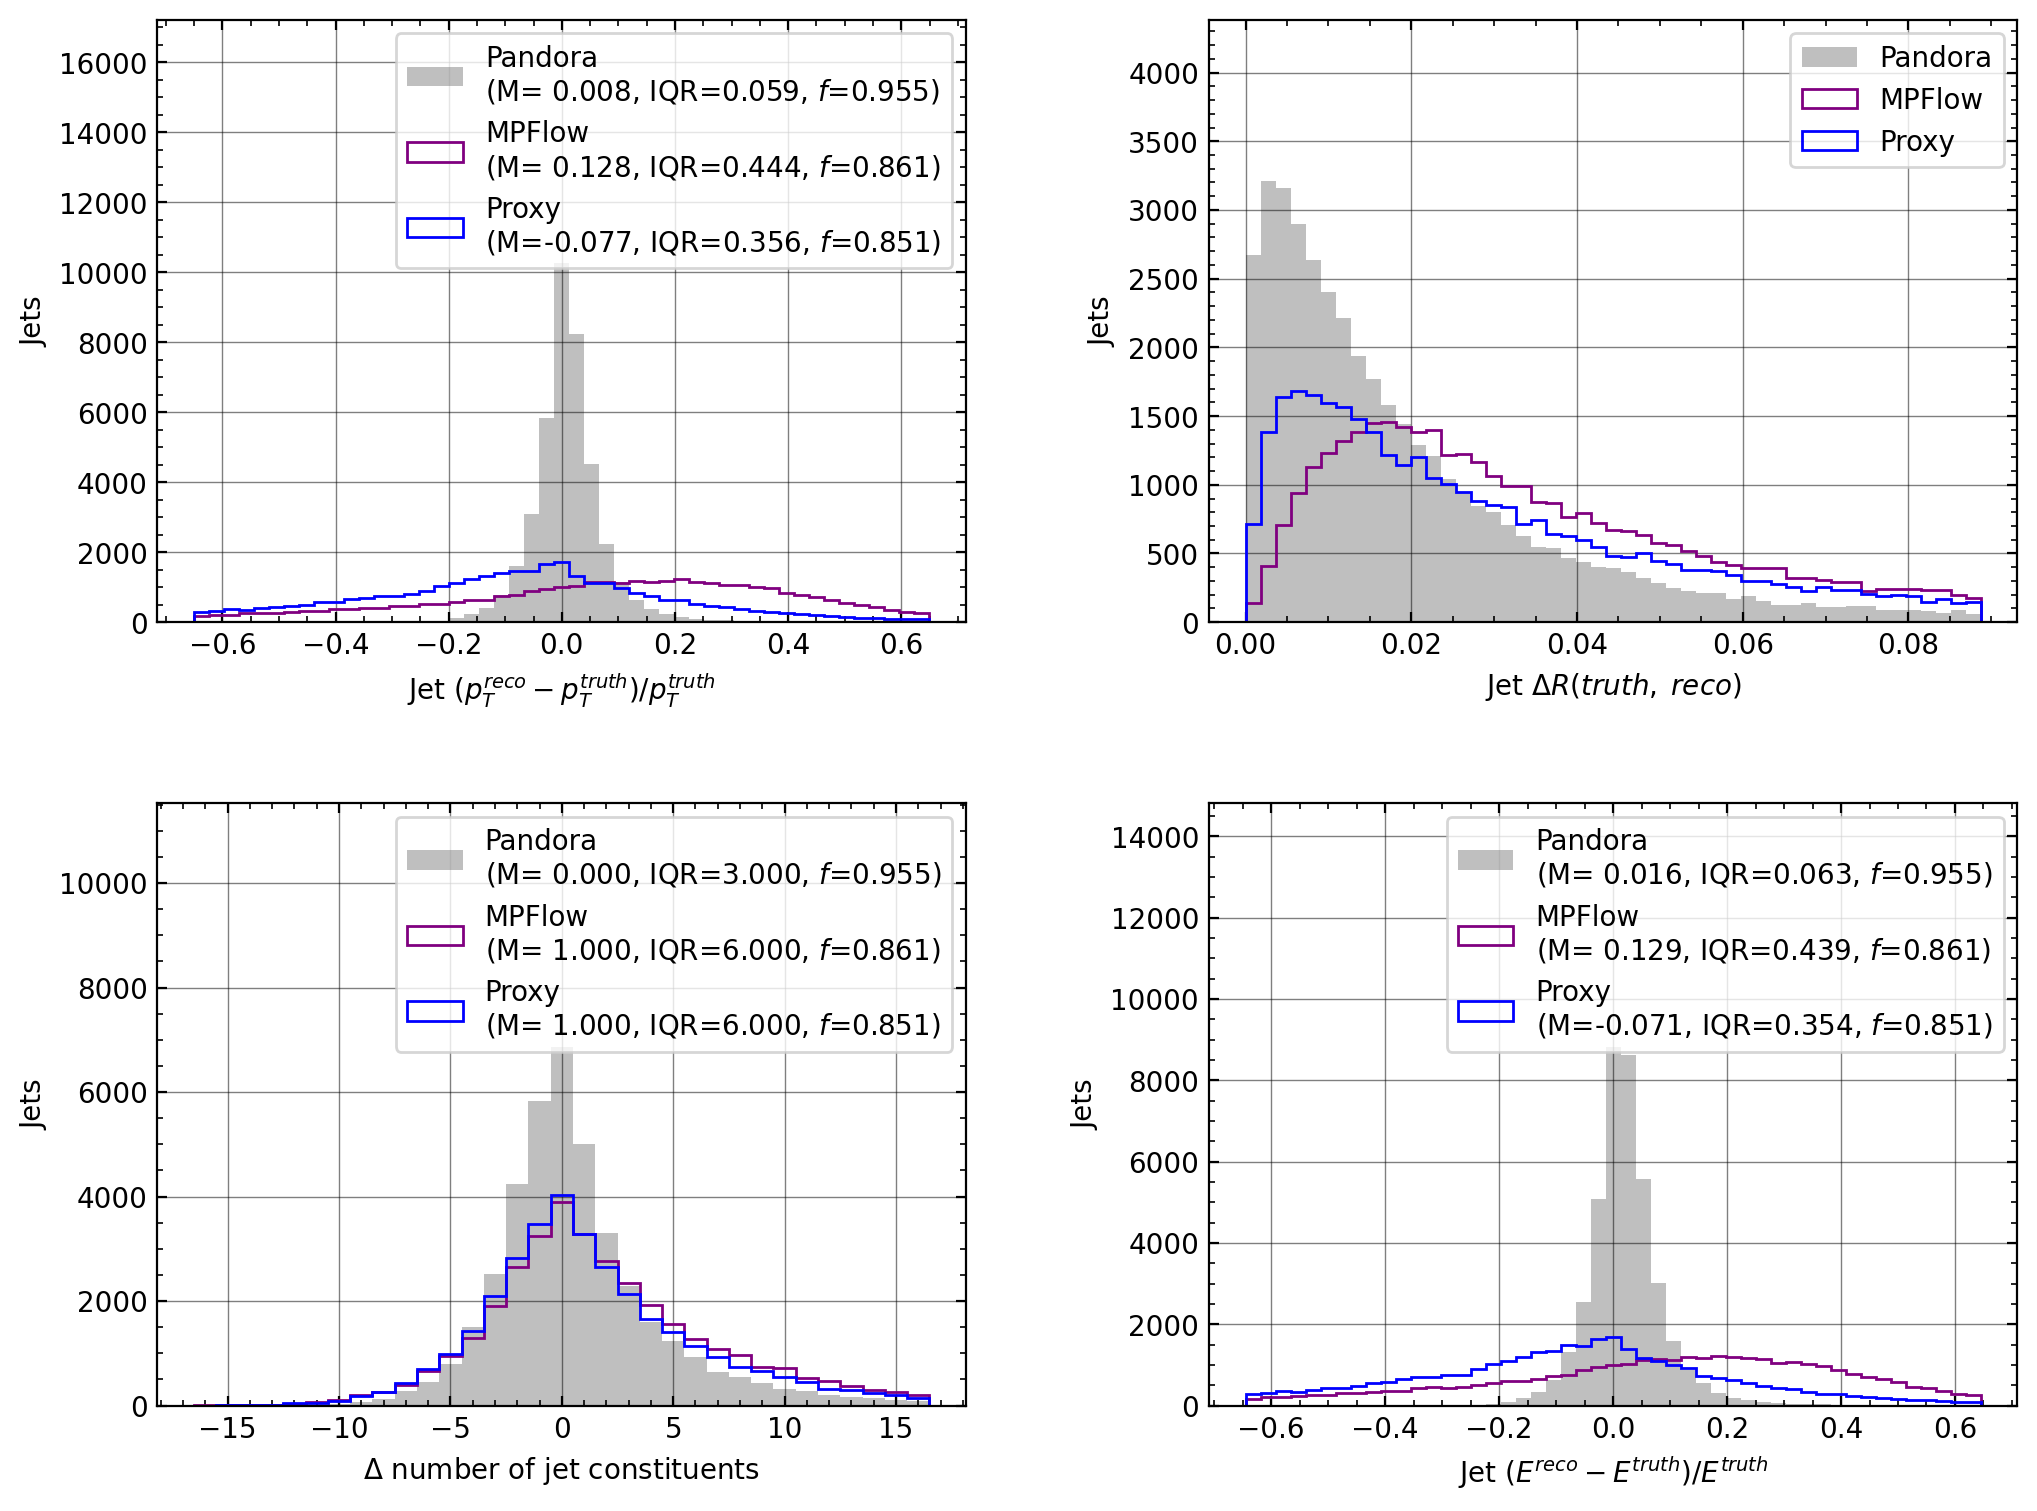

In [21]:
# change the x_lims

figs = plot_jet_residuals(jet_residual_dict, pt_relative=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/clic_dijet_jet_residuals_pt.png", dpi=300)
        figs[1].savefig(f"{save_dir}/clic_dijet_jet_residuals_dr.png", dpi=300)
        figs[2].savefig(f"{save_dir}/clic_dijet_jet_residuals_constcount.png", dpi=300)
        figs[3].savefig(f"{save_dir}/clic_dijet_jet_residuals_e.png", dpi=300)
    else:
        figs.tight_layout()
        figs.savefig(f"{save_dir}/clic_dijet_jet_residuals.png", dpi=300, bbox_inches="tight")

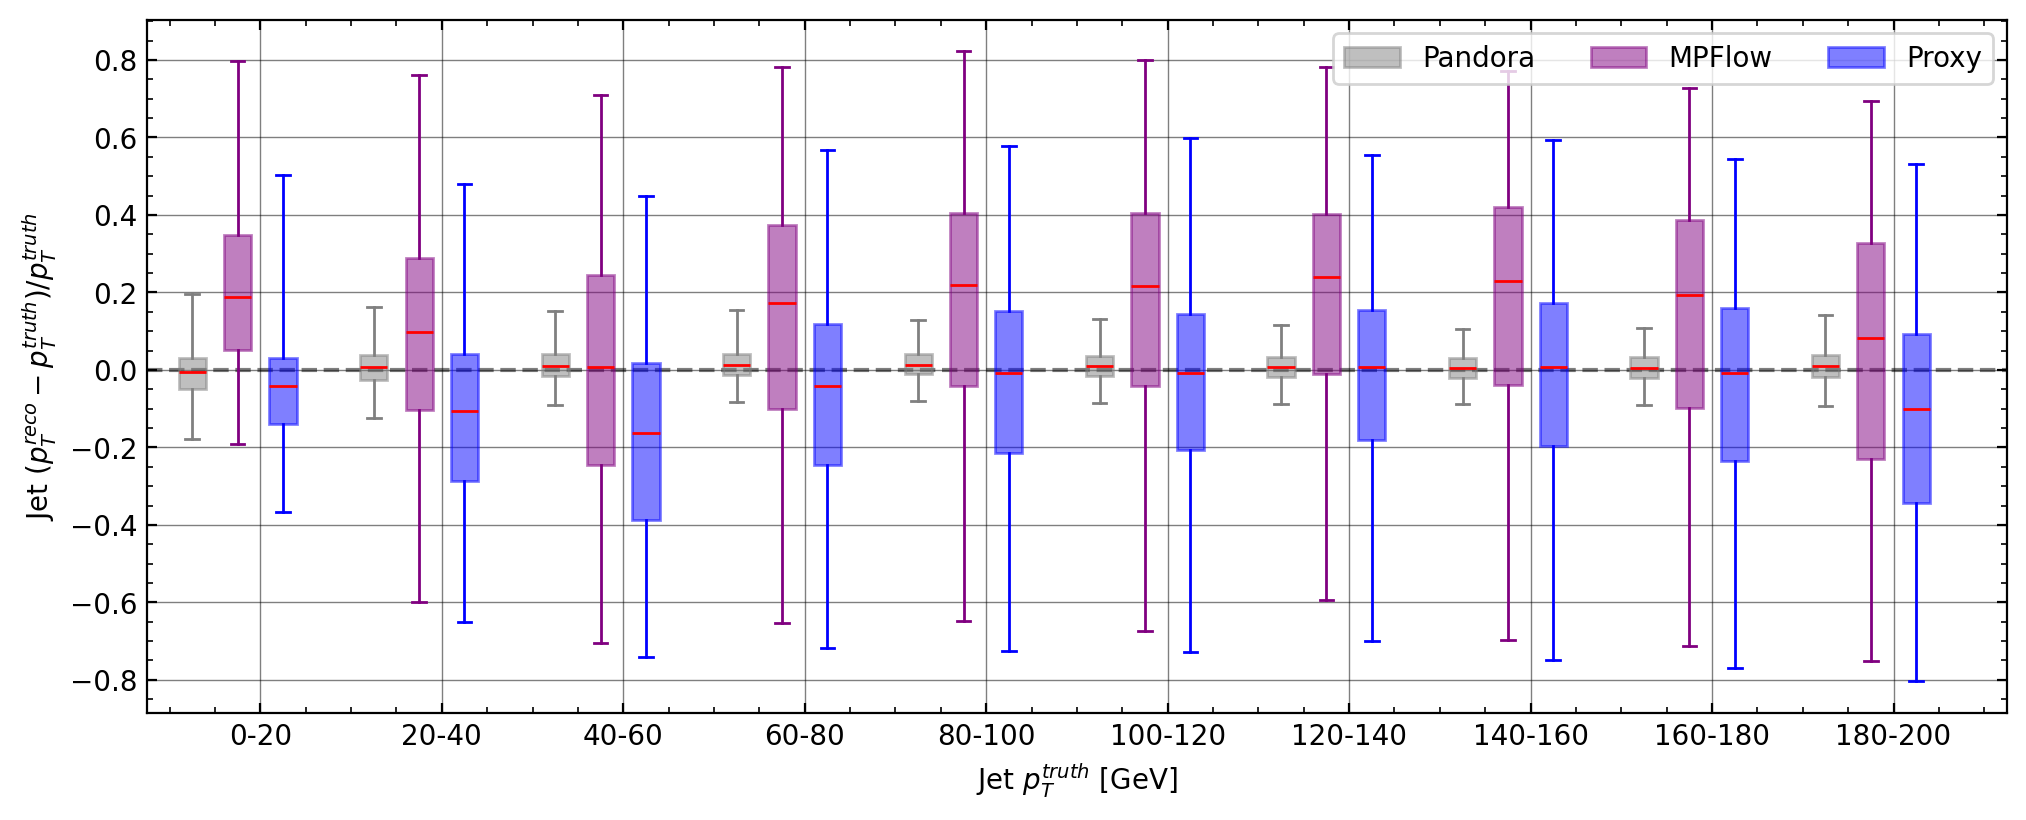

In [22]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_res_boxplot(jet_residual_dict, bins=pt_bins, var="pt")
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_residuals_boxplot_pt.png", dpi=300)

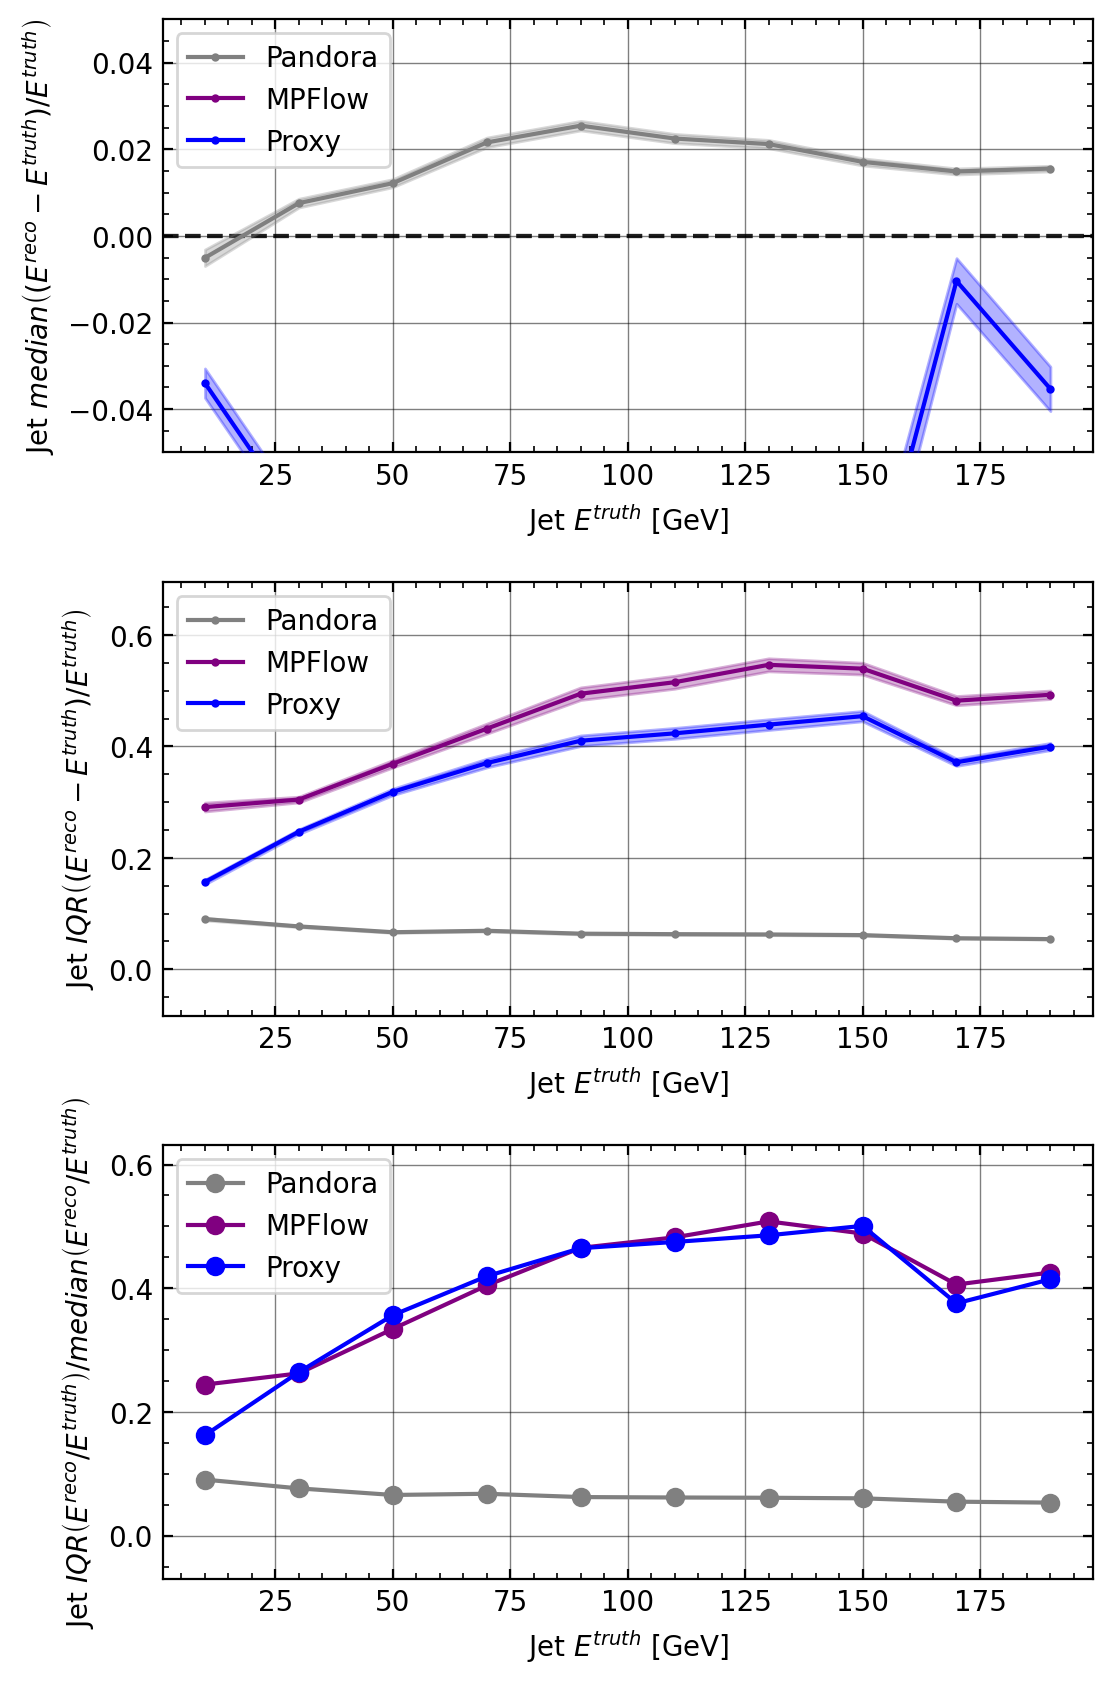

In [23]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_response(jet_residual_dict, pt_bins=pt_bins, use_energy=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(fig, list):
        for i, f in enumerate(fig):
            f.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot_{i}.png", dpi=300)
    else:
        fig.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot.png", dpi=300, bbox_inches="tight")

### jet marginal distributions

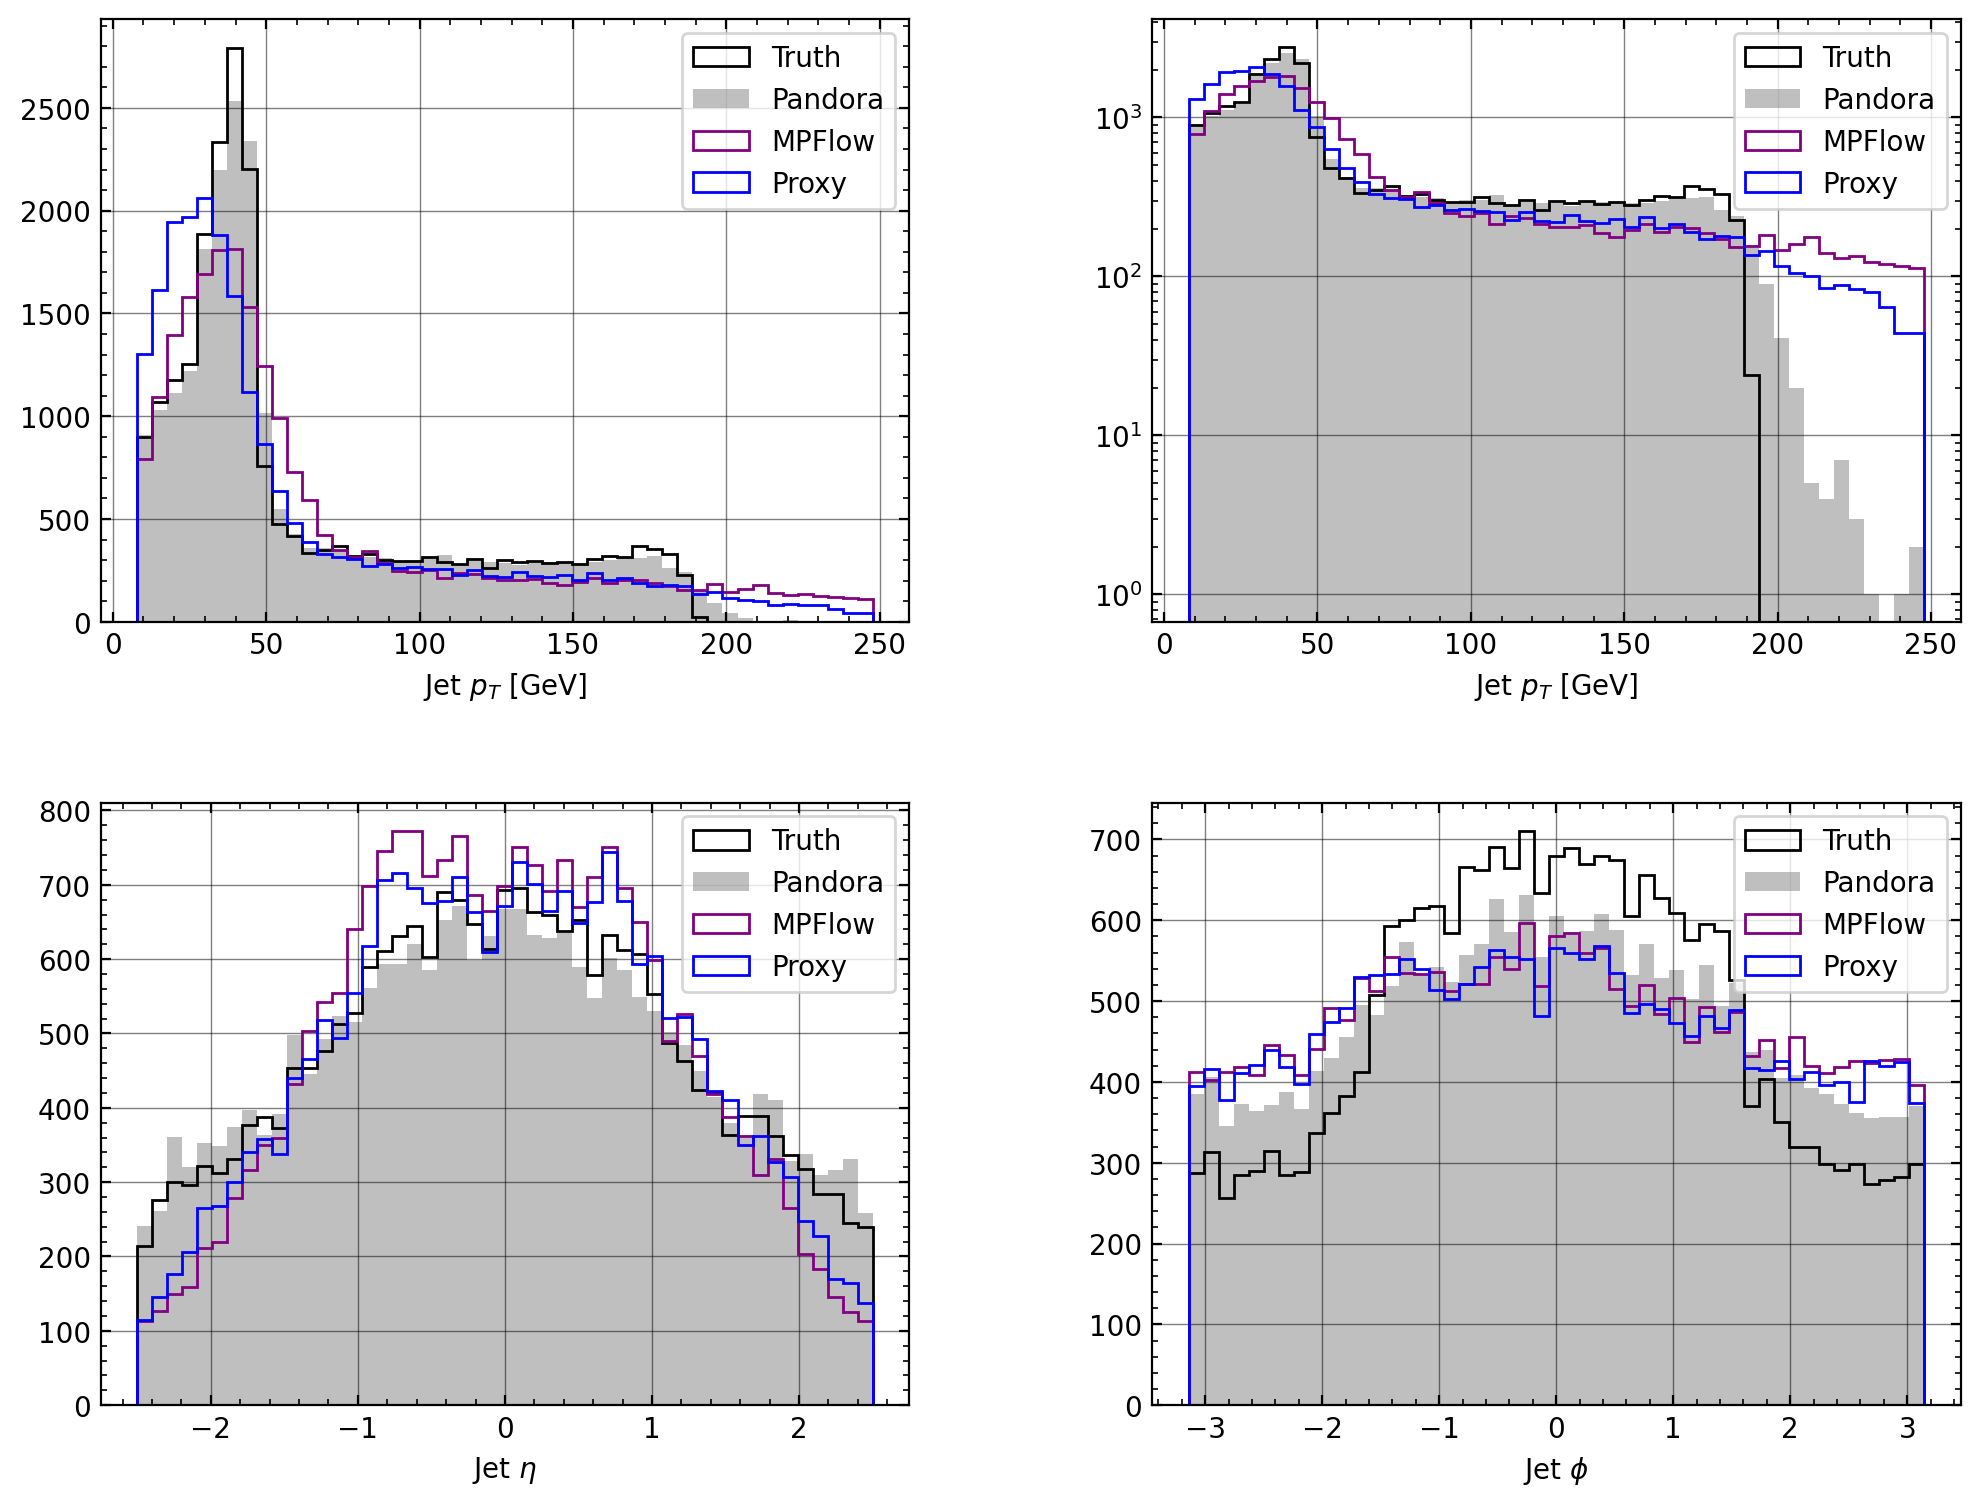

In [24]:
jet_dict = {
    "truth": perf_obj.truth_dict["truth_jets"],
    "pandora": perf_obj.truth_dict["pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['jets'],
    "mpflow": perf_obj.data["mpflow"]["jets"],
    "proxy": perf_obj.data["mpflow"]["proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["jets"],
}

fig = plot_jet_marginals(jet_dict, nleading=1, stylesheet=None)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_marginals.png", dpi=300, bbox_inches="tight")

## Particle performance

In [25]:
perf_obj.hung_match_particles(flatten=True, return_unmatched=True)

Matching particles...: 100%|████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:06<00:00, 3622.71it/s]


In [26]:
style_sheet_eff_fr = {
    "LINE_STYLES": {
        "proxy": "-",
        "mpflow": "-.",
        "pandora": "--",
    },
    "COLORS": {
        "proxy": {
            "neut had": "mediumseagreen",
            "photon": "tomato",
        },
        "mpflow": {
            "neut had": "orange",
            "photon": "darkorchid",
        },
        "pandora": {
            "neut had": "dodgerblue",
            "photon": "goldenrod",
        },
    },
}

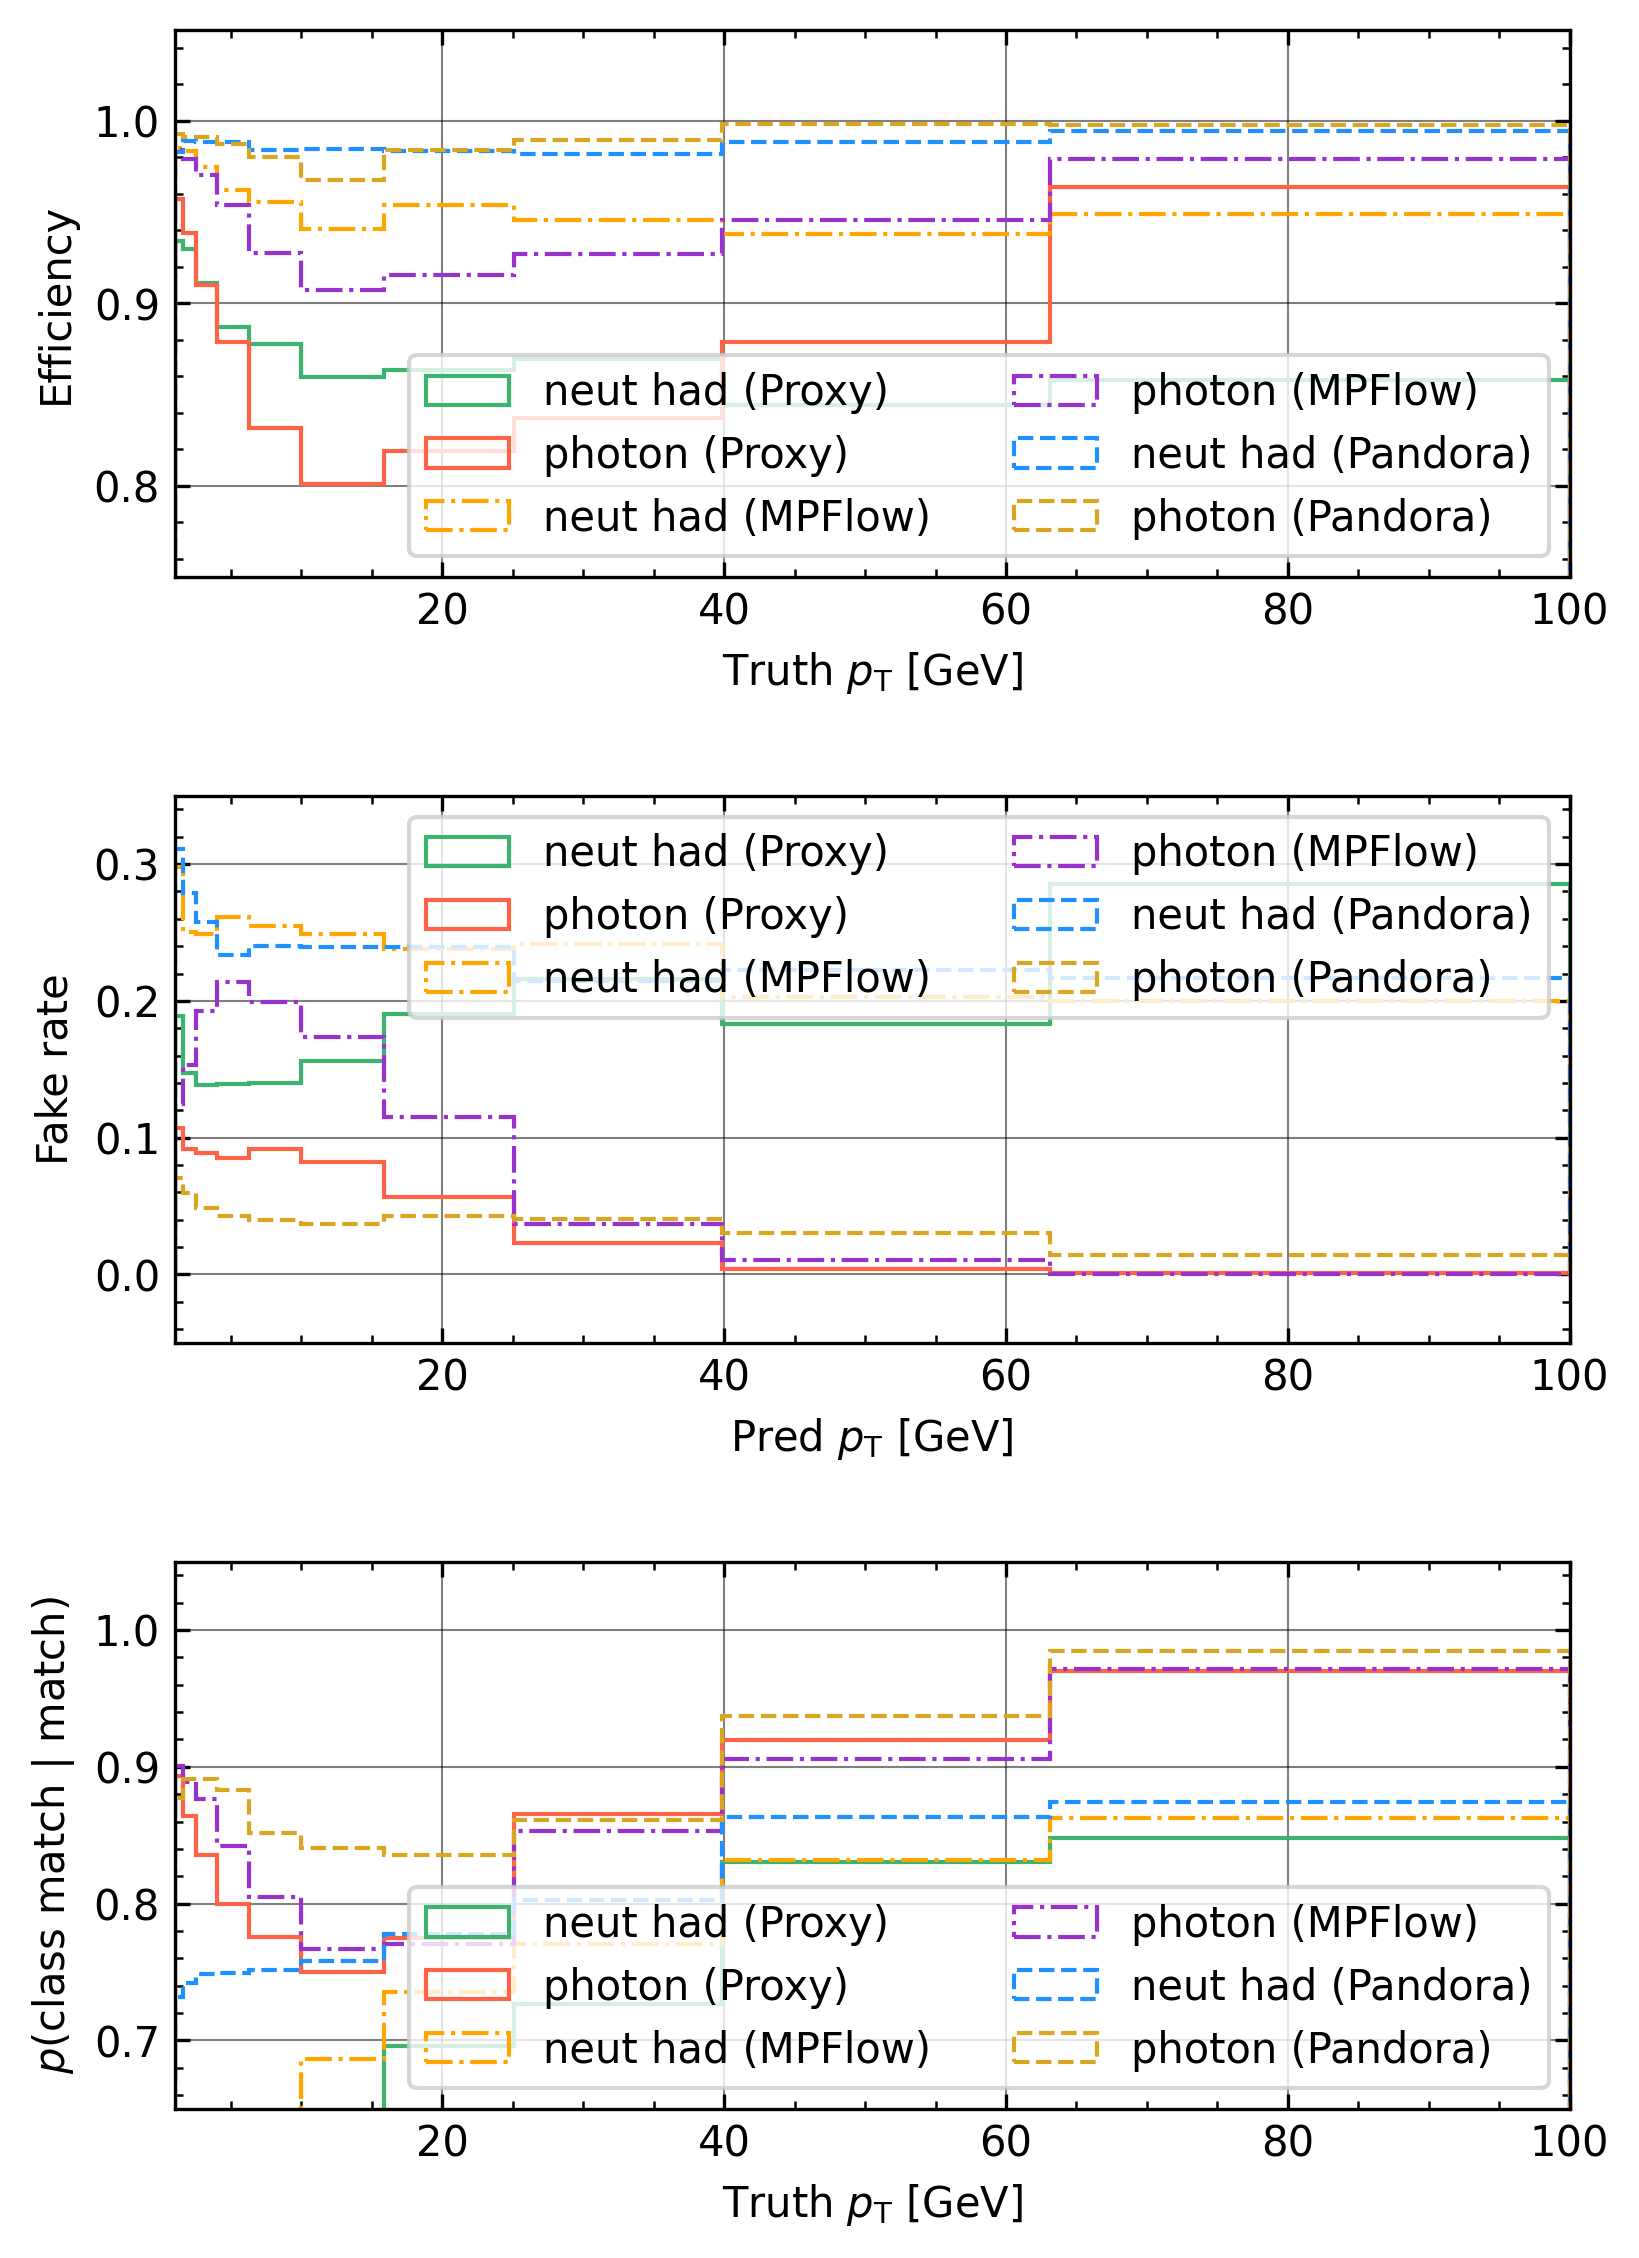

In [27]:
eff_fr_purity_input_dict = {
    "proxy": {
        "ref_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][3],
    },
    "mpflow": {
        "ref_matched": perf_obj.data["mpflow"]["matched_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_particles"][3],
    },
    "pandora": {
        "ref_matched": perf_obj.truth_dict["matched_pandora_particles"][0],
        "comp_matched": perf_obj.truth_dict["matched_pandora_particles"][1],
        "ref_unmatched": perf_obj.truth_dict["matched_pandora_particles"][2],
        "comp_unmatched": perf_obj.truth_dict["matched_pandora_particles"][3],
    },
}

fig = plot_eff_fr_purity(eff_fr_purity_input_dict, stylesheet=style_sheet_eff_fr)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_eff_fr_purity.png", dpi=300, bbox_inches="tight")

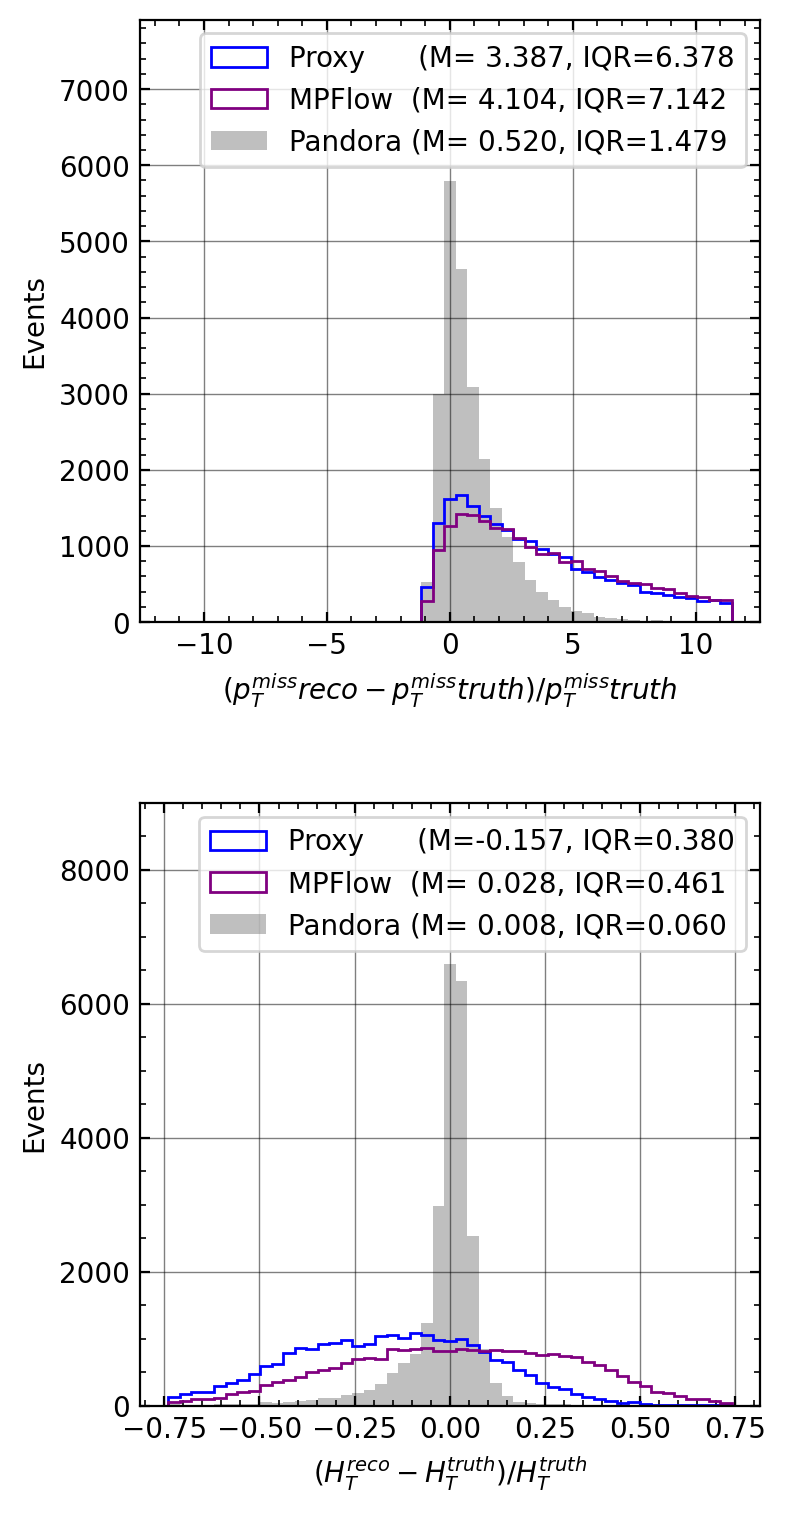

In [28]:
met_res_and_ht_res_input_dict = {
    "proxy": [perf_obj.data["mpflow"]["proxy_pt"], perf_obj.data["mpflow"]["proxy_phi"]],
    "mpflow": [perf_obj.data["mpflow"]["pt"], perf_obj.data["mpflow"]["phi"]],
    "pandora": [perf_obj.truth_dict["pandora_pt"], perf_obj.truth_dict["pandora_phi"]],
}
figs = plot_met_res_and_ht_res(
    perf_obj.truth_dict["particle_pt"], perf_obj.truth_dict["particle_phi"], met_res_and_ht_res_input_dict, stylesheet=None, separate_figures=False
)
if SAVE_FIG:
    if isinstance(figs, list):
        for i, f in enumerate(figs):
            f.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res_{i}.png", dpi=300)
    else:
        figs.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res.png", dpi=300, bbox_inches="tight")

In [ ]:
# from pflow.performance.plot_helper_particle import plot_residuals
from hepattn.experiments.clic.performance.style_sheet import LINE_STYLES

style_sheet_part_res = {
    "LINE_STYLES": deepcopy(LINE_STYLES),
}
style_sheet_part_res["LINE_STYLES"]["proxy"] = "--"
# style_sheet_part_res['COLORS']['proxy'] = 'dodgerblue'
# style_sheet_part_res['LINE_STYLES']['proxy'] = '-'

_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "mpflow": perf_obj.data["mpflow"]["matched_particles"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
}

qs = {"Charged": {"pt": 90, "eta": 80, "phi": 80}, "Neutral": {"pt": 90, "eta": 80, "phi": 80}}
fig = plot_residuals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=style_sheet_part_res)
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_particle_residuals.png", dpi=300, bbox_inches="tight")

/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:135: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))
/tmp/ipykernel_25150/907927751.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Error in callback <function _draw_all_if_interactive at 0x7f7a7f4b8c20> (for post_execute), with arguments args (),kwargs {}:


In [ ]:
_dict = {
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "mpflow": perf_obj.data["mpflow"]["matched_particles"],
}

qs = {"Neutral hadron": {"pt": 98, "eta": 75, "phi": 75}, "Photon": {"pt": 99, "eta": 90, "phi": 90}}
figs = plot_residuals_neutrals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=None, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_pt.png", dpi=300, bbox_inches="tight")
        figs[1].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_eta.png", dpi=300, bbox_inches="tight")
        figs[2].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_phi.png", dpi=300, bbox_inches="tight")
        figs[3].savefig(f"{save_dir}/dijet_particle_residuals_photon_pt.png", dpi=300, bbox_inches="tight")
        figs[4].savefig(f"{save_dir}/dijet_particle_residuals_photon_eta.png", dpi=300, bbox_inches="tight")
        figs[5].savefig(f"{save_dir}/dijet_particle_residuals_photon_phi.png", dpi=300, bbox_inches="tight")
    else:
        figs.savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_photon.png", dpi=300, bbox_inches="tight")

/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:234: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))


In [ ]:
perf_obj.hung_match_particles(flatten=False, return_unmatched=True)

Matching particles...:   0%|                                                                                              | 0/19779 [00:00<?, ?it/s]

Matching particles...: 100%|████████████████████████████████████████████████████████████████████████████████| 19779/19779 [00:06<00:00, 3151.83it/s]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_matched_event(idx):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    ref_class = perf_obj.data["mpflow"]["matched_proxy_particles"][0]["class"][idx]
    comp_class = perf_obj.data["mpflow"]["matched_proxy_particles"][1]["class"][idx]
    comp_class_hgpf = perf_obj.data["mpflow"]["matched_particles"][1]["class"][idx]
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["phi"][idx][ref_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["eta"][idx][ref_class < 3],
        marker="o",
        s=20,
        color="blue",
        label="Truth",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["phi"][idx][comp_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["eta"][idx][comp_class < 3],
        marker="x",
        s=20,
        color="orange",
        label="Proxy",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_particles"][1]["phi"][idx][comp_class_hgpf < 3],
        perf_obj.data["mpflow"]["matched_particles"][1]["eta"][idx][comp_class_hgpf < 3],
        marker="^",
        s=20,
        color="red",
        label="MPflow",
        alpha=0.5,
    )
    fig.suptitle(f"Event {idx}")
    ax.set_xlabel("Phi")
    ax.set_ylabel("Eta")
    fig.legend()
    fig.tight_layout()
    fig.show()

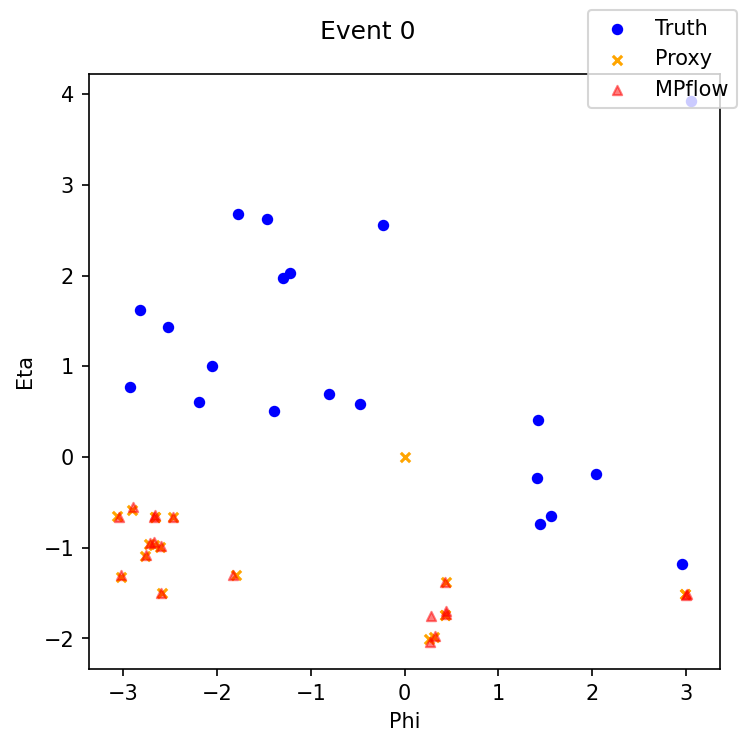

In [ ]:
plot_matched_event(0)

In [16]:
import awkward as ak

file = uproot.open("/share/gpu1/syw24/dmitrii_clic/train_clic_fix.root")
print(file.keys())
events = file["EventTree;1"]

['EventTree;1']


In [5]:
events.show(name_width=100, typename_width=50)

name                                                                                                 | typename                                           | interpretation                
-----------------------------------------------------------------------------------------------------+----------------------------------------------------+-------------------------------
ntopo                                                                                                | int32_t                                            | AsDtype('>i4')
topo_x                                                                                               | float[]                                            | AsJagged(AsDtype('>f4'))
topo_y                                                                                               | float[]                                            | AsJagged(AsDtype('>f4'))
topo_z                                                                                       

In [15]:
np.unique(ak.flatten(events["particle_pdgid"].arrays()["particle_pdgid"]))

<Array [-3334, -3322, -3312, ..., 1000020060, 1000030040] type='43 * int32'>